In [1]:
from pystencils.session import *
import timeit
%load_ext Cython

# Demo: Benchmark numpy, cython, pystencils

In this benchmark we compare different ways of implementing a simple stencil kernel in Python.
The benchmark kernel computes the average of the four neighbors in 2D and stores in a second array. To prevent out-of-bounds accesses, we skip the cells at the border and compute values only in the range `[1:-1, 1:-1]`

## Implementations

The first implementation is a pure Python implementation:

In [2]:
def avg_pure_python(input_arr, output_arr):       
    for x in range(1, input_arr.shape[0] - 1):
        for y in range(1, input_arr.shape[1] - 1):
            output_arr[x, y] = (input_arr[x + 1, y] + input_arr[x - 1, y] +
                                input_arr[x, y + 1] + input_arr[x, y - 1]) / 4

Obviously, this will be a rather slow version, since the loops are written directly in Python. 

Next, we use *numpy* functions to delegate the looping to numpy. The first version uses the `roll` function to shift the array by one element in each direction. This version has to allocate a new array for each accessed neighbor.

In [3]:
def avg_numpy_roll(input_arr, output_arr):
    neighbors = [np.roll(input_arr, axis=a, shift=s) for a in (0, 1) for s in (-1, 1)]
    np.divide(sum(neighbors), 4, out=output_arr)

Using views, we can get rid of the additional copies:

In [4]:
def avg_numpy_slice(input_arr, output_arr):
    output_arr[1:-1, 1:-1] = input_arr[2:, 1:-1] + input_arr[:-2, 1:-1] + \
                             input_arr[1:-1, 2:] + input_arr[1:-1, :-2]
    

To further optimize the kernel we switch to Cython, to get a compiled C version.

In [5]:
%%cython
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def avg_cython(object[double, ndim=2] input_arr, object[double, ndim=2] output_arr):
    cdef int xs, ys, x, y
    xs, ys = input_arr.shape
    for x in range(1, xs - 1):
        for y in range(1, ys - 1):
            output_arr[x, y] = (input_arr[x + 1, y] + input_arr[x - 1, y] +
                                input_arr[x, y + 1] + input_arr[x, y - 1]) / 4

And finally we also create a *pystencils* version of the same stencil code:

In [6]:
src, dst = ps.fields("src, dst: [2D]")

update = ps.Assignment(dst[0,0], 
                       (src[1, 0] + src[-1, 0] + src[0, 1] + src[0, -1]) / 4)
kernel = ps.create_kernel(update).compile()

def avg_pystencils(input_arr, output_arr):
    kernel(src=input_arr, dst=output_arr)

In [28]:
all_implementations = {
    'pure Python': avg_pure_python,
    'numpy roll': avg_numpy_roll,
    'numpy slice': avg_numpy_slice,
    'Cython': None,
    'pystencils': avg_pystencils,
}
if 'avg_cython' in globals():
    all_implementations['Cython'] = avg_cython
else:
    del all_implementations['Cython']

## Benchmark functions

We implement a short function to get in- and output arrays of a given shape and to measure the runtime.

In [29]:
def get_arrays(shape):
    in_arr = np.random.rand(*shape)
    out_arr = np.empty_like(in_arr)
    return in_arr, out_arr

def do_benchmark(func, shape):
    in_arr, out_arr = get_arrays(shape)
    timer = timeit.Timer('f(a, b)', globals={'f': func, 'a': in_arr, 'b': out_arr})
    calls, time_taken = timer.autorange()
    return time_taken / calls

## Comparison


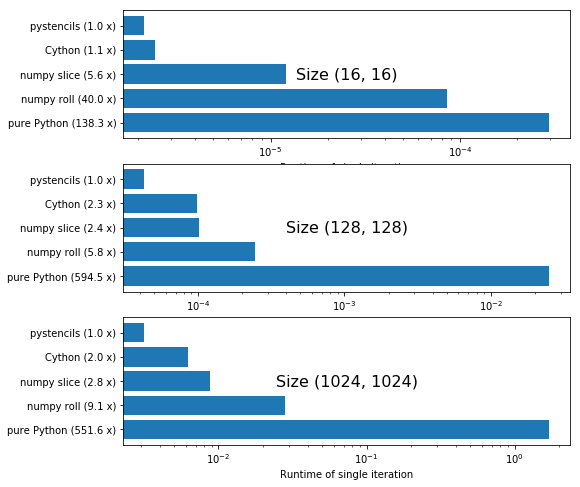

In [40]:
def bar_plot(*shape):
    names = tuple(all_implementations.keys())
    runtimes = tuple(do_benchmark(all_implementations[name], shape) for name in names)
    for runtime, name in zip(runtimes, names):
        assert runtime >= runtimes[names.index('pystencils')], runtimes
    speedups = tuple(runtime / min(runtimes) for runtime in runtimes)
    y_pos = np.arange(len(names))
    labels = tuple(f"{name} ({round(speedup, 1)} x)" for name, speedup in zip(names, speedups))
    
    plt.text(0.5, 0.5, f"Size {shape}", horizontalalignment='center', fontsize=16,
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.barh(y_pos, runtimes, log=True)
     
    plt.yticks(y_pos, labels);
    plt.xlabel('Runtime of single iteration')
    
plt.figure(figsize=(8, 8))
    
plt.subplot(3, 1, 1)
bar_plot(16, 16)

plt.subplot(3, 1, 2)
bar_plot(128, 128)

plt.subplot(3, 1, 3)
bar_plot(1024, 1024)

All runtimes are plotted logarithmically. Next number next to the labels shows how much slower the version is than the fastest one. For small arrays Cython produces faster code than *pystencils*. The larger the arrays, the better pystencils gets.